<a href="https://colab.research.google.com/github/samtam0714/data-analysis-google/blob/master/PCA_Cancer_Class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [ ]:
# load dataset
dataset=pd.read_csv('./cancer.csv')
dataset.head()

,id,Clump Thickness,UofCSize,UofCShape,Marginal Adhesion,SECSize,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [ ]:
#Remove Model from Dataset
dataset=dataset.drop('id',axis=1)
dataset.head()

,Clump Thickness,UofCSize,UofCShape,Marginal Adhesion,SECSize,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,5,1,1,1,2,1,3,1,1,2
1,5,4,4,5,7,10,3,2,1,2
2,3,1,1,1,2,2,3,1,1,2
3,6,8,8,1,3,4,3,7,1,2
4,4,1,1,3,2,1,3,1,1,2


In [ ]:
#Create x and y variables
x = dataset.drop('Class', axis=1).values
Y = dataset['Class'].values

#Load Library for Training
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,Y,test_size = 0.2,stratify=Y,random_state = 100)

#Fix the imbalanced Classes
from imblearn.over_sampling import SMOTE
smt=SMOTE(random_state=100)
x_train_smt,y_train_smt = smt.fit_resample(x_train,y_train)

#Scale the Data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()  
X_train = sc.fit_transform(x_train_smt)  
X_test = sc.transform(x_test)

x_2=sc.transform(x)

#Import Models
from sklearn.linear_model import LogisticRegression

C:\Users\100274743\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\100274743\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\100274743\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\100274743\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [ ]:
# Determine Number of Components for DR
from sklearn.decomposition import PCA

#PCA Ratios
pca_none = PCA(n_components=None)
X_pca = pca_none.fit(x_2, Y)
pca_var_ratios = pca_none.explained_variance_ratio_

# Create a function
def select_n_components(var_ratio, goal_var: float) -> int:
    # Set initial variance explained so far
    total_variance = 0.0
    
    # Set initial number of features
    n_components = 0
    
    # For the explained variance of each feature:
    for explained_variance in var_ratio:
        
        # Add the explained variance to the total
        total_variance += explained_variance
        
        # Add one to the number of components
        n_components += 1
        
        # If we reach our goal level of explained variance
        if total_variance >= goal_var:
            # End the loop
            break
            
    # Return the number of components
    return n_components

#Number of components
n_comppca=select_n_components(pca_var_ratios, 0.95)

In [ ]:
# Construct some pipelines 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

#Create Pipeline

pipeline =[]

pipe_logreg = Pipeline([('scl', StandardScaler()),
                     ('reduce_dim', PCA(n_comppca)),
                    ('clf', LogisticRegression(solver='liblinear',
                                                        class_weight='balanced',
                                                        random_state=100))])
pipeline.insert(0,pipe_logreg)

modelpara =[]

param_gridlogreg = {'clf__C': [0.01, 0.1, 1, 10, 100], 
                    'clf__penalty': ['l1', 'l2']}
modelpara.insert(0,param_gridlogreg)

In [ ]:
#Define Gridsearch Function

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score

def Gridsearch_cv(model, params):
    
    #Cross-validation Function
    cv2=RepeatedKFold(n_splits=10, n_repeats=5, random_state=100)
        
    #GridSearch CV
    gs_clf = GridSearchCV(model, params, n_jobs=-1, cv=cv2)
    gs_clf = gs_clf.fit(X_train, y_train_smt)
    model = gs_clf.best_estimator_
    
    #Nested CV
    scoreACC = cross_val_score(gs_clf, x_2, Y, 
                             scoring='accuracy', cv=5,
                             n_jobs= -1)
    
    scorePM = cross_val_score(gs_clf, x_2, Y, 
                             scoring='precision_weighted', cv=5,
                             n_jobs= -1)
    
    scoreRM = cross_val_score(gs_clf, x_2, Y, 
                             scoring='recall_weighted', cv=5,
                             n_jobs= -1)
    
    # Use best model and test data for final evaluation
    y_pred = model.predict(X_test)

    #Identify Best Parameters to Optimize the Model
    bestpara=str(gs_clf.best_params_)
    
    #Output Heading
    print('\nOptimized Model')
    print('\nModel Name:',str(pipeline.named_steps['clf']))
    print('\n')    
   
    #Output Validation Statistics
    target_names=['Class 1','Class 2']
    print('Best Parameters:',bestpara)
    print('\nNumber of PCA components:',n_comppca)
    print('\nExplained Variance-PCA : ',np.round(model.named_steps['reduce_dim'].explained_variance_ratio_,2))
    print('\nConfusion Matrix and Classification Report')
    print('\n', confusion_matrix(y_test,y_pred))  
    print('\n',classification_report(y_test,y_pred,target_names=target_names)) 
    print('\nNestedCV Accuracy(weighted) :{:0.2f} +/-{:0.2f} '.format(np.mean(scoreACC),np.std(scoreACC)))
    print('NestedCV Precision(weighted) :{:0.2f} +/-{:0.2f} '.format(np.mean(scoreACC),np.std(scorePM)))
    print('NestedCV Recall(weighted) :{:0.2f} +/-{:0.2f} '.format(np.mean(scoreACC),np.std(scoreRM)))
    print('\n')
    
    #Visualize Explained Variance
    print('Explained Variances')
    for exv in [model.named_steps['reduce_dim'].explained_variance_ratio_]:
        cumsum = np.cumsum(exv)*100
        d = [n for n in range(1,len(cumsum)+1)]
        plt.figure(figsize=(10, 5))
        plt.plot(d,cumsum, color = 'red',label='cumulative explained variance')
        plt.title('Cumulative Explained Variance as a Function of the Number of Components')
        plt.ylabel('Cumulative Explained variance')
        plt.xlabel('Principal components')
        plt.axhline(y = 95, color='k', linestyle='--', label = '95% Explained Variance')
        plt.legend(loc='best')
        plt.show()
        
    #Feature Distribution
    '''
    Each column of the matrix shows the weights in the linear 
    combination which obtains the corresponding principal component
    '''
    print('\nPCA Components by Feature Weight')

    pcacomponents = model.named_steps['reduce_dim'].components_.T
    PCAdataset = pd.DataFrame(np.round(pcacomponents,2), 
                              columns=['PC-1','PC-2','PC-3','PC-4','PC-5','PC-6','PC-7'],
                              index=dataset.drop('Class', axis=1).columns)
    print('\n',PCAdataset)    


Optimized Model

Model Name: LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=100,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)


Best Parameters: {'clf__C': 1, 'clf__penalty': 'l1'}

Number of PCA components: 7

Explained Variance-PCA :  [0.63 0.09 0.06 0.06 0.05 0.04 0.03]

Confusion Matrix and Classification Report

 [[89  0]
 [ 2 46]]

               precision    recall  f1-score   support

     Class 1       0.98      1.00      0.99        89
     Class 2       1.00      0.96      0.98        48

   micro avg       0.99      0.99      0.99       137
   macro avg       0.99      0.98      0.98       137
weighted avg       0.99      0.99      0.99       137


NestedCV Accuracy(weighted) :0.97 +/-0.02 
NestedCV Precision(weighted) :0.97 +/-0.02 
NestedCV Recall(weighted) :0.97 +/-0.02 


Explained Variances


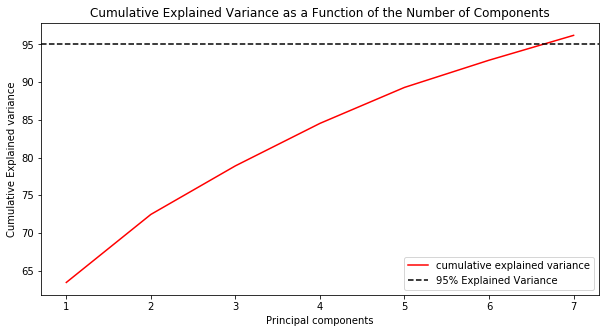


PCA Components by Feature Weight

                    PC-1  PC-2  PC-3  PC-4  PC-5  PC-6  PC-7
Clump Thickness    0.30 -0.25  0.80  0.09 -0.03  0.43  0.04
UofCSize           0.38 -0.05 -0.11  0.20  0.23 -0.02  0.13
UofCShape          0.38 -0.08 -0.01  0.19  0.19 -0.23  0.11
Marginal Adhesion  0.33 -0.00 -0.34 -0.63 -0.09  0.57 -0.10
SECSize            0.34  0.22 -0.15  0.22  0.59  0.10 -0.44
Bare Nuclei        0.33 -0.28  0.18 -0.52 -0.05 -0.64 -0.26
Bland Chromatin    0.35 -0.15 -0.26  0.06 -0.09 -0.04  0.72
Normal Nucleoli    0.33 -0.01 -0.19  0.43 -0.72  0.00 -0.39
Mitoses            0.22  0.88  0.27 -0.15 -0.17 -0.13  0.17


In [ ]:
#Run Models

for pipeline, modelpara in zip(pipeline,modelpara):
    Gridsearch_cv(pipeline,modelpara)

In [ ]:
#PCA BiPlot 

pca = PCA(n_components=2).fit(x_2)
x_new2 = pca.fit_transform(x_2)
reduced_data = pca.transform(x_2)
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])

def biplot(data, reduced_data, pca):

    #Set Figure Size
    fig, ax = plt.subplots(figsize = (15,10))

    #Create Scatter Plot
    scatter=plt.scatter(x_new2[:,0], x_new2[:,1], c = Y)
    labels = np.unique(Y)
    handles = [plt.Line2D([],[],marker="o", ls="", 
                      color=scatter.cmap(scatter.norm(yi))) for yi in labels]
    plt.legend(handles, labels)
    
    #Identify PCA Components
    feature_vectors = pca.components_.T

    # using scaling factors to make the arrows
    arrow_size, text_pos = 4.0, 4.5,

    # projections of the original features
    for i, v in enumerate(feature_vectors):
        ax.arrow(0, 0, arrow_size*v[0], arrow_size*v[1], head_width=0.2, 
                 head_length=0.2, linewidth=1, color='red')
        ax.text(v[0]*text_pos, v[1]*text_pos, dataset.columns[i], color='black', 
                ha='left', va='center', fontsize=10)

    ax.set_xlabel("Dimension 1", fontsize=9)
    ax.set_ylabel("Dimension 2", fontsize=9)
    ax.set_title("PCA with Feature Projections.", fontsize=18);
    return ax

PCA BiPlot


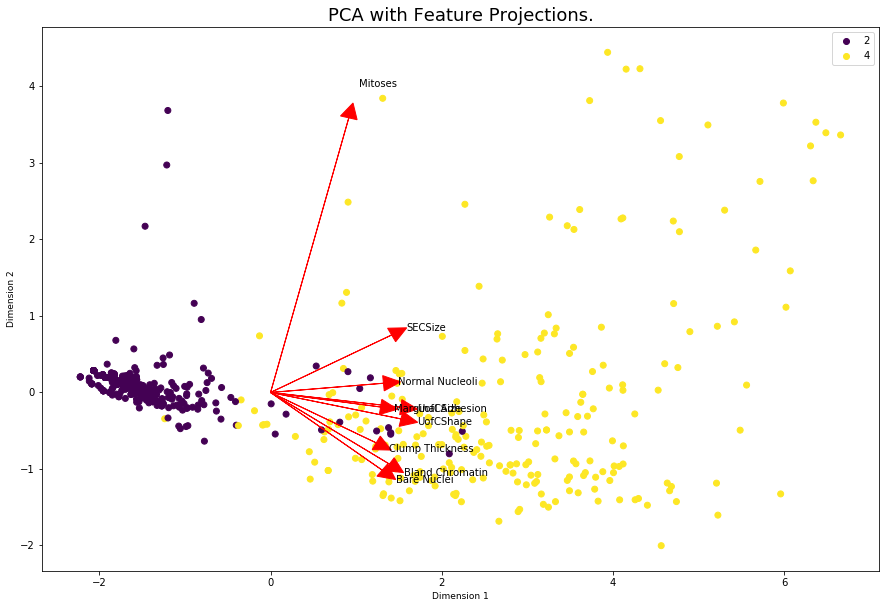

In [ ]:
#Print BiPlot
print('PCA BiPlot')
biplot(x_2, reduced_data, pca)